# Candidate feature importance

In [1]:
import collections
import copy
from pathlib import Path

from geo_transformers.data_loading import TransformedDataset
from geo_transformers.models.any_horizon_forecast_transformer import AnyHorizonForecastTransformerCLI, SelectionHead
from geo_transformers import notebook_utils, training_utils
import pandas as pd
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import yaml
import wandb

## Load model and data

In [2]:
ENTITY = "lirmm-zenith"
PROJECT = "geo-transformers"

def load_run(run_id):
    run_path = f"{ENTITY}/{PROJECT}/{run_id}"
    run_dir = Path(f"exp/forecast_mbk+ung_12h/{PROJECT}/{run_id}")

    if (run_dir / "config.yaml").exists():
        f = open(run_dir / "config.yaml")
    else:
        run_dir.mkdir(exist_ok=True)
        f = wandb.restore("config.yaml", run_path=run_path, root=run_dir)
    with f:
        config_dict = yaml.load(f, Loader=yaml.SafeLoader)
    config_dict = config_dict["fit"]["value"]
    config_dict["trainer"]["logger"] = False
    del config_dict["seed_everything"], config_dict["ckpt_path"]

    config, objects = notebook_utils.load_experiment(AnyHorizonForecastTransformerCLI, config_dict)
    
    return run_dir, config, objects

In [3]:
run_id = "37ld98g9"

In [4]:
with notebook_utils.chdir(".."):
    run_dir, config, objects = load_run(run_id)

    [ckpt_path] = sorted((run_dir / "checkpoints").glob("*-best.ckpt"))
    print(ckpt_path)

    model = objects["model"]
    dmodule = objects["data"]

    model.load_state_dict(torch.load(ckpt_path)["state_dict"])
    
    dmodule.setup(stage="predict")
    dataset_raw = dmodule.test_dataloader().dataset
    dataset_raw.preprocess_fn = lambda x: x
    dataset_raw.num_candidates = 16
    dataset_raw = list(tqdm(dataset_raw))

model.cuda()
model.train(False)

dataset = TransformedDataset(dataset_raw, dmodule.processor.encode)
dloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    collate_fn=training_utils.collate_sequence_dicts,
    num_workers=0
)

exp/forecast_mbk+ung_12h/geo-transformers/37ld98g9/checkpoints/epoch=169-step=23629-best.ckpt


  0%|          | 0/151 [00:00<?, ?it/s]

## Run prediction

In [5]:
def cat_padded(tensors):
    max_len = max(t.shape[1] for t in tensors)
    return torch.cat(
        [F.pad(t, (0, 0) * (len(t.shape) - 2) + (0, max_len - t.shape[1])) for t in tensors],
        axis=0
    )

In [6]:
def permute_feature(batch, feat_name, feat_dim, rng_seed=None):
    if rng_seed is None:
        rng_seed = batch["mask"].sum().item()
    feat_index = () if feat_dim is None else (..., feat_dim)
    feat = batch[feat_name][feat_index]
    shuffle_idxs = np.arange(feat.shape[2])[None, None, :]
    shuffle_idxs = np.broadcast_to(shuffle_idxs, shape=feat.shape[:3])
    shuffle_idxs = np.random.default_rng(rng_seed).permuted(shuffle_idxs, axis=2)
    if feat.ndim > shuffle_idxs.ndim:
        shuffle_idxs = shuffle_idxs[..., None]
    shuffle_idxs = np.broadcast_to(shuffle_idxs, shape=feat.shape)
    shuffle_idxs = torch.tensor(shuffle_idxs, device=model.device)
    batch[feat_name][feat_index] = torch.gather(feat, index=shuffle_idxs, dim=2)
    return batch

In [7]:
def ablate_feature_median(batch, feat_name, feat_dim):
    feat_index = (...,) if feat_dim is None else (..., feat_dim)
    if torch.is_floating_point(batch[feat_name]):
        batch[feat_name][feat_index] = torch.median(batch[feat_name][feat_index], dim=2, keepdim=True).values
    else:
        batch[feat_name][feat_index] = torch.mode(batch[feat_name][feat_index], dim=2, keepdim=True).values
    return batch

In [8]:
FEATS = [
    (None, None),
    ("location_cand", None),
    ("location_cand_mov", None),
    ("humfoot_cand", None),
    ("landcover_cand", None),
    ("bioclim_cand", None),
]
FEATS.extend(
    ("bioclim_cand", j) for j in range(19)
)

In [9]:
mask, preds_abl = [], collections.defaultdict(lambda: collections.defaultdict(list))
with torch.inference_mode():
    for i, batch_orig in enumerate(tqdm(dloader)):
        for feat_name, feat_dim in tqdm(FEATS, leave=False):
            for method in ["permute", "median"]:
                batch = dmodule.transfer_batch_to_device(copy.deepcopy(batch_orig), device=model.device, dataloader_idx=0)

                if feat_name is not None:
                    feat_key = feat_name + (f"[{feat_dim+1}]" if feat_dim is not None else "")
                    if method == "permute":
                        permute_feature(batch, feat_name, feat_dim)
                    else:
                        ablate_feature_median(batch, feat_name, feat_dim)
                else:
                    feat_key = "none"

                pred, _, _ = model(batch)
                pred = pred.log_softmax(dim=-1)
                preds_abl[method][feat_key].append(pred.cpu())
            if feat_name is None:
                mask.append(batch["mask"].cpu())
mask = cat_padded(mask)
preds_abl = {k: {vk: cat_padded(vv) for vk, vv in v.items()} for k, v in preds_abl.items()}

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

## Compute metrics

In [10]:
def compute_accuracies(preds, mask, k=1, num_candidates=None):
    assert num_candidates is None or preds.shape[-1] >= num_candidates
    hits = (preds[..., :num_candidates].topk(k, dim=-1).indices == 0).any(dim=-1)
    return ((hits * mask).sum(dim=-1) / mask.sum(dim=-1))

In [11]:
# NOTE: Should use the same number of candidates as above due to permutation

results = []
for feat_key in tqdm(preds_abl["permute"].keys()):
    for method in preds_abl.keys():
        preds = preds_abl[method][feat_key]
        log_n = np.log(preds.shape[-1])
        tgt_oh = F.one_hot(torch.zeros(preds.shape[:-1], dtype=int), num_classes=preds.shape[-1])
        xent = F.kl_div(preds, tgt_oh, log_target=False, reduction="none").sum(dim=-1) / log_n
        results.append(pd.DataFrame({
            "method": method,
            "feat": feat_key,
            "seq_id": np.arange(len(mask)),
            "-xent@16": -((xent * mask).sum(dim=1) / mask.sum(dim=1)),
            "acc 8/16": compute_accuracies(preds, mask, 8, 16),
            "acc 1/16": compute_accuracies(preds, mask, 1, 16),
        }))

results = pd.concat(results)

  0%|          | 0/25 [00:00<?, ?it/s]

### Save/load metrics

In [12]:
results.to_csv("mbk+ung_12h_feat_imp_results.csv", index=False)

In [13]:
results = pd.read_csv("mbk+ung_12h_feat_imp_results.csv")

## Compute feature importances

In [14]:
results_base = results.query("feat == 'none'").set_index(["method", "seq_id"]).drop(columns="feat")
results_diff = (
    results
    .query("feat != 'none'")
    .groupby("feat")
    .apply(lambda df: results_base - df.set_index(["method", "seq_id"]).drop(columns="feat"))
    .reset_index()
)

In [15]:
results_diff.query("method == 'permute'").drop(columns=["seq_id", "method"]).groupby("feat").mean().sort_values(by="-xent@16")

,-xent@16,acc 8/16,acc 1/16
feat,,,
location_cand,0.000006,-0.000049,0.000238
bioclim_cand[7],0.000311,-0.000286,0.000601
bioclim_cand[8],0.000312,0.000385,0.000687
bioclim_cand[18],0.000564,0.001472,0.001400
bioclim_cand[5],0.000625,0.001643,0.001556
bioclim_cand[9],0.000646,0.000051,0.002648
bioclim_cand[1],0.000700,0.000942,0.001641
bioclim_cand[19],0.000702,0.000593,0.001295
bioclim_cand[3],0.000932,0.000449,0.002697


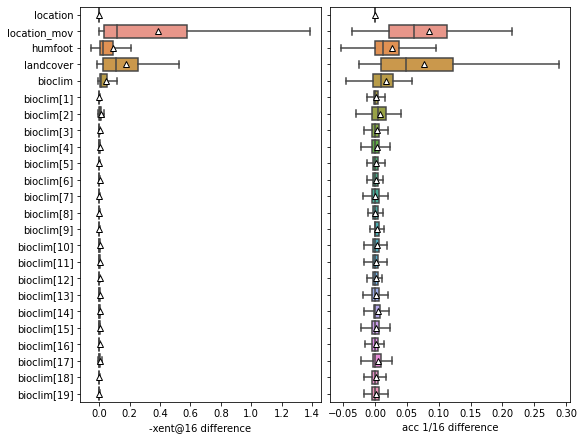

In [16]:
for method in ["permute"]:
    fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=True, constrained_layout=True)
    for metric, ax in zip(["-xent@16", "acc 1/16"], axes):
        g = sns.boxplot(
            data=results_diff.query("method == @method")[["feat", metric]].melt(id_vars=["feat"]),
            x="value", y="feat", order=results.query("feat != 'none'")["feat"].unique(),
            showmeans=True, showfliers=False,
            meanprops=dict(markerfacecolor="white", markeredgecolor="black"), ax=ax)
        ax.set_xlabel(metric + " difference")
        ax.set_ylabel(None)
    axes[0].set_yticklabels([l.get_text().replace("_cand", "") for l in axes[0].get_yticklabels()])
    plt.savefig(f"figs/feat_imp_{method}.pdf", bbox_inches="tight")
    plt.show()